In [1]:
# Inspect data and plot figures
from collections import defaultdict
from typing import List

import numpy as np

from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
plt.style.use("seaborn-poster")
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (10, 6)

import pandas as pd

# Paths to data
base = "../data/final_neg_base.csv"
opt = "../data/final_neg_opt.csv"
seq = "../data/sequential.csv"

# Load data
base = pd.read_csv(base, header=None)
opt = pd.read_csv(opt, header=None)
seq = pd.read_csv(seq, header=None)

header = ["SIZE", "NODES", "CPUS_PER_NODE", "NBODIES", "RTIME", "GFLOPS"]
base.set_axis(header, axis=1, inplace=True)
opt.set_axis(header, axis=1, inplace=True)
seq.set_axis(["NBODIES", "RTIME", "GFLOPS"], axis=1, inplace=True)

In [2]:
def speedup(serial_rtime: float, parallel_rtime: float) -> float:
    return serial_rtime/parallel_rtime

def efficiency(speedup_val: float, n_procs: int) -> float:
    return speedup_val/n_procs

def generic_performance_plot(
    df: pd.DataFrame, 
    plot_ideal_performance: bool, 
    plot_log: List[bool], 
    annotate: bool, 
    *args, **kwargs):
    """Plot plot nprocs on x-axi, performance metric on y axis, and use df index as legend.
    
    Args:
        df: Data to plot.
        plot_ideal_performance: True to plot linear metric, false otherwise.
        plot_log: True to plot x-axis as log scale, false otherwise.
        annotate: True to annotate x-value of point on y value.
        *args: For MPL.
        **kwargs: For MPL.

    Returns:
        Figure and axes for performance plot
    """
    if len(plot_log) != 2:
        raise ValueError(
            f"`plot_log` must be a list of two bools, but [{plot_log}] was provided ")

    # Vars for indexing plot log
    x, y = 0, 1

    fig, ax = plt.subplots()

    x_data = np.array([int(it) for it in df.columns])
    for row_index, metric in df.iterrows():
        if plot_log[x] and not plot_log[y]:
            ax_plotter = ax.semilogx
        elif not plot_log[x] and plot_log[y]:
            ax_plotter = ax.semilogy
        elif plot_log[x] and plot_log[y]:
            ax_plotter = ax.loglog
        else:
            ax_plotter = ax.plot

        ax_plotter(x_data, metric.values, label=f"N={row_index}", *args, **kwargs)

    if plot_ideal_performance:
        ax_plotter(x_data, x_data, "--", color="k", alpha=0.50, label="Ideal", **kwargs)

    if annotate:
        for i, x_pt in enumerate(x_data):
            ax.annotate(x_pt, (x_data[i], metric.values[i]))

    if plot_log[x]:
        ax.set_xticks(x_data)
        ax.get_xaxis().set_major_formatter(ScalarFormatter())

    # if plot_log[y]:
    #     ax.set_yticks(metric.values)
    #     ax.get_yaxis().set_major_formatter(ScalarFormatter())

    return fig, ax

# Describe
## Initial Observations
* Min and Max of Optimized rtime is lower
* Mean of optimized program is actually lower
* How does scalability compare (i.e., as N increases, how do the strategies compare w.r.t rtime)?

## What Should Figures Show
* Speedup = serial rtime / parallel rtime # @ n-processes
* Efficiency = Speedup / n-processes
* Hard vs. Weak Scaling
* Serial Performance

In [3]:
base.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GFLOPS
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,35.000000,4.333333,5.395833,3908.000000,30.440368,1.759861
std,38.929738,2.365250,6.255871,3788.029434,67.983186,1.988681
min,2.000000,2.000000,1.000000,512.000000,0.161000,0.220000
25%,7.500000,2.000000,1.000000,896.000000,0.703000,0.530000
50%,20.000000,4.000000,1.000000,2560.000000,2.589500,0.885000
75%,40.000000,6.000000,7.000000,5572.000000,22.683250,2.247500
max,128.000000,8.000000,16.000000,10000.000000,380.922000,9.220000


In [4]:
base[base["GFLOPS"] == base["GFLOPS"].max()]

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GFLOPS
143,128,8,16,10000,10.842,9.22


In [5]:
base[(base["NBODIES"] == 10000) & (base["SIZE"] == 2)]["RTIME"]

36     380.922
84     380.862
132    379.953
Name: RTIME, dtype: float64

In [6]:
opt.describe()

,SIZE,NODES,CPUS_PER_NODE,NBODIES,RTIME,GFLOPS
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,35.000000,3.958333,3.458333,3908.000000,20.080660,1.738958
std,38.929738,2.173827,4.634735,3788.029434,45.097283,1.988537
min,2.000000,2.000000,1.000000,512.000000,0.146000,0.020000
25%,7.500000,2.000000,1.000000,896.000000,3.012000,0.225000
50%,20.000000,4.000000,1.000000,2560.000000,13.602000,1.080000
75%,40.000000,6.000000,4.000000,5572.000000,16.931250,2.562500
max,128.000000,8.000000,16.000000,10000.000000,312.353000,9.150000


# Summary Statistics

In [7]:
NBODIES = base["NBODIES"].unique()
SIZE = sorted(base["SIZE"].unique())
print("NBODIES=", NBODIES)
print("SIZE=", SIZE)

# Store summary statistics
base_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
opt_mean_std = {"SIZE": [], "NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}
seq_mean_std = {"NBODIES": [], "MEAN_RTIME": [], "STD_RTIME": []}

# Get summary statistics for parameters of interest
for nbody in NBODIES:
    seq_duplicated: pd.DataFrame = seq[(seq["NBODIES"] == nbody)]

    seq_mean = seq_duplicated["RTIME"].mean()
    seq_std = seq_duplicated["RTIME"].std()

    seq_mean_std["NBODIES"].append(nbody)
    seq_mean_std["MEAN_RTIME"].append(seq_mean)
    seq_mean_std["STD_RTIME"].append(seq_std)

    for size in SIZE:
        base_duplicated: pd.DataFrame = base[(base["NBODIES"] == nbody) & (base["SIZE"] == size)]
        opt_duplicated: pd.DataFrame = opt[(opt["NBODIES"] == nbody) & (opt["SIZE"] == size)]

        base_mean = base_duplicated["RTIME"].mean()
        base_std = base_duplicated["RTIME"].mean()

        opt_mean = opt_duplicated["RTIME"].mean()
        opt_std = opt_duplicated["RTIME"].std()

        base_mean_std["SIZE"].append(size)
        base_mean_std["NBODIES"].append(nbody)
        base_mean_std["MEAN_RTIME"].append(base_mean)
        base_mean_std["STD_RTIME"].append(base_std)

        opt_mean_std["SIZE"].append(size )
        opt_mean_std["NBODIES"].append(nbody)
        opt_mean_std["MEAN_RTIME"].append(opt_mean)
        opt_mean_std["STD_RTIME"].append(opt_std)

# Make dataframes
base_mean_std = pd.DataFrame(base_mean_std)
opt_mean_std = pd.DataFrame(opt_mean_std)
seq_mean_std = pd.DataFrame(seq_mean_std)

NBODIES= [  512  1024  4096 10000]
SIZE= [2, 4, 6, 8, 16, 24, 32, 64, 96, 128]


In [8]:
display(seq_mean_std)
display(base_mean_std)
display(opt_mean_std)

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.195333,1.195333
1,4,512,0.806667,0.806667
2,6,512,0.586333,0.586333
3,8,512,0.518333,0.518333
4,16,512,0.359000,0.359000
5,24,512,0.220667,0.220667
6,32,512,0.398833,0.398833
7,64,512,0.321667,0.321667
8,96,512,0.200333,0.200333
9,128,512,0.775667,0.775667


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,0.976000,0.010817
1,4,512,0.256000,0.011533
2,6,512,0.149333,0.004163
3,8,512,1.479000,1.441321
4,16,512,2.877000,0.015875
5,24,512,2.828667,0.038109
6,32,512,8.472333,5.969147
7,64,512,13.991000,0.207964
8,96,512,13.898667,0.110564
9,128,512,14.378000,0.096814


# Speedups and Efficiencies

In [9]:
display(seq_mean_std)
display(base_mean_std.head())
display(opt_mean_std.head())

,NBODIES,MEAN_RTIME,STD_RTIME
0,512,1.553333,0.004933
1,1024,5.598333,0.006807
2,4096,86.540333,0.238383
3,10000,511.479333,0.552442


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,1.195333,1.195333
1,4,512,0.806667,0.806667
2,6,512,0.586333,0.586333
3,8,512,0.518333,0.518333
4,16,512,0.359000,0.359000


,SIZE,NBODIES,MEAN_RTIME,STD_RTIME
0,2,512,0.976000,0.010817
1,4,512,0.256000,0.011533
2,6,512,0.149333,0.004163
3,8,512,1.479000,1.441321
4,16,512,2.877000,0.015875


In [10]:
# TODO: Should calculate these first and then take averagess
base_speedup_efficiency = defaultdict(list)
opt_speedup_efficiency = defaultdict(list)

for nbody in NBODIES:
    seq_mean_rtime = seq_mean_std[seq_mean_std["NBODIES"] == nbody]["MEAN_RTIME"].values[0]
    for size in SIZE:
        base_mean_rtime_at_params = base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]
        opt_mean_rtime_at_params = opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0]


        base_speedup = speedup(seq_mean_rtime, base_mean_rtime_at_params)
        base_efficiency = efficiency(base_speedup, size)
        opt_speedup = speedup(seq_mean_rtime, opt_mean_rtime_at_params)
        opt_efficiency = efficiency(opt_speedup, size)

        base_speedup_efficiency["SIZE"].append(size)
        base_speedup_efficiency["NBODIES"].append(nbody)
        base_speedup_efficiency["SPEEDUP"].append(base_speedup)
        base_speedup_efficiency["EFFICIENCY"].append(base_efficiency)

        opt_speedup_efficiency["SIZE"].append(size)
        opt_speedup_efficiency["NBODIES"].append(nbody)
        opt_speedup_efficiency["SPEEDUP"].append(opt_speedup)
        opt_speedup_efficiency["EFFICIENCY"].append(opt_efficiency)

# make dataframes
base_speedup_efficiency = pd.DataFrame(base_speedup_efficiency)
opt_speedup_efficiency = pd.DataFrame(opt_speedup_efficiency)

In [11]:
base_speedup_efficiency

,SIZE,NBODIES,SPEEDUP,EFFICIENCY
0,2,512,1.299498,0.649749
1,4,512,1.925620,0.481405
2,6,512,2.649233,0.441539
3,8,512,2.996785,0.374598
4,16,512,4.326834,0.270427
5,24,512,7.039275,0.293303
6,32,512,3.894693,0.121709
7,64,512,4.829016,0.075453
8,96,512,7.753744,0.080768
9,128,512,2.002578,0.015645


# Tables

In [12]:
# For presentation
base_speedup_presentation = {p: [] for p in SIZE}
base_efficiency_presentation = {p: [] for p in SIZE}
base_rtime_presentation = {p: [] for p in [1] + SIZE}

opt_speedup_presentation = {p: [] for p in SIZE}
opt_efficiency_presentation = {p: [] for p in SIZE}
opt_rtime_presentation = {p: [] for p in [1] + SIZE}

for nbody in NBODIES:
    for size in SIZE:
        # speedup and efficiency entries
        base_speedup_efficiency_at_params = base_speedup_efficiency[
            (base_speedup_efficiency["NBODIES"] == nbody) 
            & (base_speedup_efficiency["SIZE"] == size)]
        opt_speedup_efficiency_at_params = opt_speedup_efficiency[
            (opt_speedup_efficiency["NBODIES"] == nbody) 
            & (opt_speedup_efficiency["SIZE"] == size)]

        # runtime entries
        base_mean_rtime_at_params = round(base_mean_std[
            (base_mean_std["NBODIES"] == nbody) & (base_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)
        opt_mean_rtime_at_params = round(opt_mean_std[
            (opt_mean_std["NBODIES"] == nbody) & (opt_mean_std["SIZE"] == size)]["MEAN_RTIME"].values[0],
            2)

        # Get presentable speedup and efficiencies
        base_speedup_at_params = round(base_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        base_efficiency_at_params = round(base_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        opt_speedup_at_params = round(opt_speedup_efficiency_at_params["SPEEDUP"].values[0], 2)
        opt_efficiency_at_params = round(opt_speedup_efficiency_at_params["EFFICIENCY"].values[0] * 100, 2)

        # Update the presentation dicts
        base_speedup_presentation[size].append(base_speedup_at_params)
        base_efficiency_presentation[size].append(base_efficiency_at_params)
        base_rtime_presentation[size].append(base_mean_rtime_at_params)

        opt_speedup_presentation[size].append(opt_speedup_at_params)
        opt_efficiency_presentation[size].append(opt_efficiency_at_params)
        opt_rtime_presentation[size].append(opt_mean_rtime_at_params)

# update the first size entry of the runtime dataframe with the entries
# from the sequential entry
base_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))
opt_rtime_presentation[1] = seq_mean_std["MEAN_RTIME"].apply(lambda ele: round(ele, 2))

# cast to dataframes and set indices
base_speedup_presentation = pd.DataFrame(base_speedup_presentation)
base_speedup_presentation.set_index(NBODIES, inplace=True)

base_efficiency_presentation = pd.DataFrame(base_efficiency_presentation)
base_efficiency_presentation.set_index(NBODIES, inplace=True) 

base_rtime_presentation = pd.DataFrame(base_rtime_presentation)
base_rtime_presentation.set_index(NBODIES, inplace=True)

opt_speedup_presentation = pd.DataFrame(opt_speedup_presentation)
opt_speedup_presentation.set_index(NBODIES, inplace=True)

opt_efficiency_presentation = pd.DataFrame(opt_efficiency_presentation)
opt_efficiency_presentation.set_index(NBODIES, inplace=True) 

opt_rtime_presentation = pd.DataFrame(opt_rtime_presentation)
opt_rtime_presentation.set_index(NBODIES, inplace=True)


In [13]:
print("Base Speedup, Efficiency, and Runtimes")
display(base_speedup_presentation)
display(base_efficiency_presentation)
display(base_rtime_presentation)
print()
print("OpenMP Optimized Speedup, Efficiency, and Runtimes") 
display(opt_speedup_presentation)
display(opt_efficiency_presentation)
display(opt_rtime_presentation)

Base Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
512,1.30,1.93,2.65,3.00,4.33,7.04,3.89,4.83,7.75,2.00
1024,1.33,2.17,2.95,3.61,5.64,8.11,7.64,8.89,13.39,6.33
4096,1.35,2.31,3.27,4.17,7.62,11.29,13.32,22.33,33.67,33.37
10000,1.34,2.31,3.29,4.20,7.90,11.75,14.14,25.14,37.42,45.56


,2,4,6,8,16,24,32,64,96,128
512,64.97,48.14,44.15,37.46,27.04,29.33,12.17,7.55,8.08,1.56
1024,66.55,54.32,49.18,45.14,35.22,33.77,23.88,13.89,13.95,4.95
4096,67.53,57.65,54.42,52.17,47.63,47.05,41.62,34.90,35.08,26.07
10000,67.20,57.64,54.80,52.52,49.35,48.96,44.18,39.28,38.98,35.59


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,1.20,0.81,0.59,0.52,0.36,0.22,0.40,0.32,0.20,0.78
1024,5.60,4.21,2.58,1.90,1.55,0.99,0.69,0.73,0.63,0.42,0.88
4096,86.54,64.08,37.53,26.51,20.73,11.35,7.66,6.50,3.87,2.57,2.59
10000,511.48,380.58,221.84,155.56,121.74,64.78,43.53,36.18,20.35,13.67,11.23



OpenMP Optimized Speedup, Efficiency, and Runtimes


,2,4,6,8,16,24,32,64,96,128
512,1.59,6.07,10.40,1.05,0.54,0.55,0.18,0.11,0.11,0.11
1024,1.62,7.00,11.49,3.24,1.88,1.90,0.65,0.40,0.40,0.39
4096,1.64,5.85,9.40,13.91,15.25,18.55,7.54,5.26,5.57,5.53
10000,1.64,7.80,12.91,14.14,24.16,38.16,19.35,18.14,21.65,23.67


,2,4,6,8,16,24,32,64,96,128
512,79.58,151.69,173.36,13.13,3.37,2.29,0.57,0.17,0.12,0.08
1024,81.14,175.09,191.46,40.54,11.76,7.91,2.03,0.62,0.42,0.30
4096,81.90,146.31,156.67,173.85,95.29,77.30,23.56,8.22,5.80,4.32
10000,81.96,194.95,215.22,176.70,151.00,158.99,60.46,28.34,22.56,18.49


,1,2,4,6,8,16,24,32,64,96,128
512,1.55,0.98,0.26,0.15,1.48,2.88,2.83,8.47,13.99,13.90,14.38
1024,5.60,3.45,0.80,0.49,1.73,2.97,2.95,8.64,14.04,14.00,14.51
4096,86.54,52.83,14.79,9.21,6.22,5.68,4.66,11.48,16.45,15.54,15.65
10000,511.48,312.01,65.59,39.61,36.18,21.17,13.40,26.44,28.20,23.62,21.61


In [14]:
# Write tables to disk
base_speedup_presentation.to_csv("../figures/pure_mpi_speedup.csv", index=True)
base_efficiency_presentation.to_csv("../figures/pure_mpi_efficiency.csv", index=True)
base_rtime_presentation.to_csv("../figures/pure_mpi_rtime.csv", index=True)

opt_speedup_presentation.to_csv("../figures/hybrid_mpi_speedup.csv", index=True)
opt_efficiency_presentation.to_csv("../figures/hybrid_mpi_efficiency.csv", index=True)
opt_rtime_presentation.to_csv("../figures/hybrid_mpi_rtime.csv", index=True)

# Pure MPI Figures

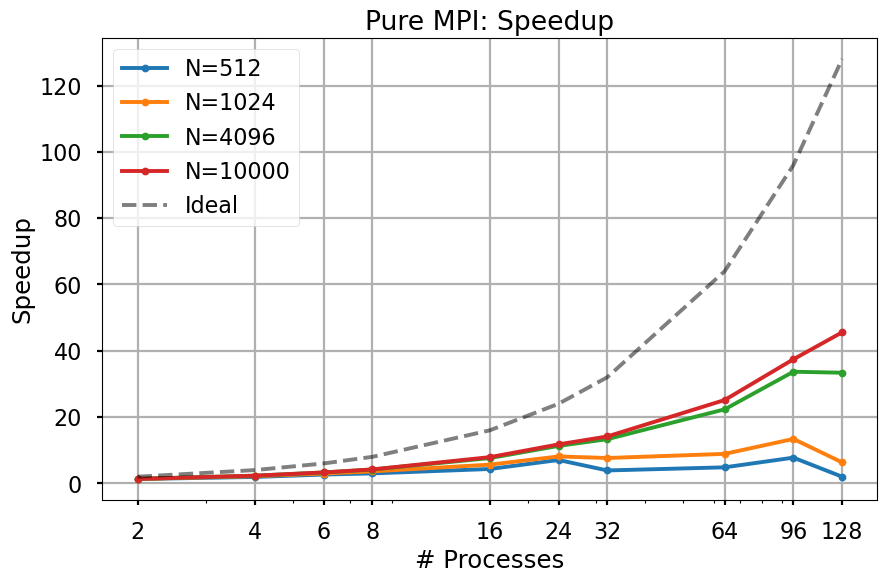

In [15]:
# Speedup
fig_base_speedup, ax_base_speedup = generic_performance_plot(base_speedup_presentation, True, [True, False], False, ".-")
ax_base_speedup.legend()
ax_base_speedup.set_title("Pure MPI: Speedup")
ax_base_speedup.set_xlabel("# Processes")
ax_base_speedup.set_ylabel("Speedup")

fig_base_speedup.savefig("../figures/pure_mpi_speedup.png", bbox_inches="tight")

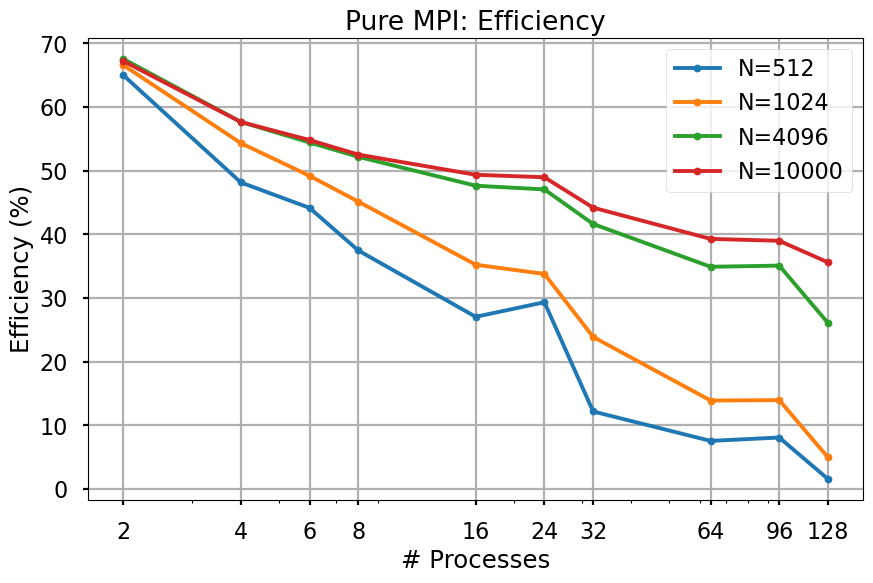

In [16]:
# Efficiencies
fig_base_efficiency, ax_base_efficiency = generic_performance_plot(base_efficiency_presentation, False, [True, False], False, ".-")
ax_base_efficiency.legend()
ax_base_efficiency.set_title("Pure MPI: Efficiency")
ax_base_efficiency.set_xlabel("# Processes")
ax_base_efficiency.set_ylabel("Efficiency (%)")

fig_base_efficiency.savefig("../figures/pure_mpi_efficiency.png", bbox_inches="tight")

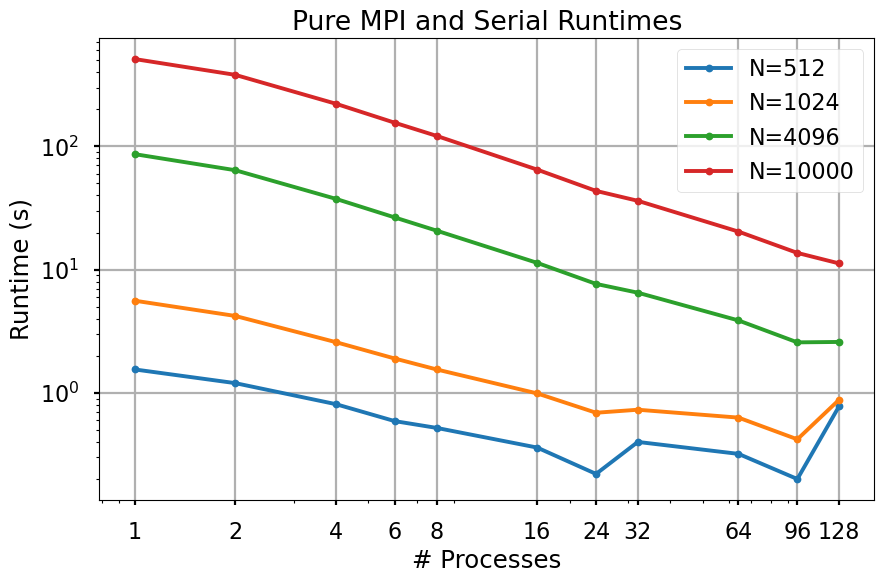

In [17]:
# Run times
# TODO: Log scale this
fig_base_rtime, ax_base_rtime = generic_performance_plot(base_rtime_presentation, False, [True, True], False, ".-")
ax_base_rtime.legend()
ax_base_rtime.set_title("Pure MPI and Serial Runtimes")
ax_base_rtime.set_xlabel("# Processes")
ax_base_rtime.set_ylabel("Runtime (s)")

fig_base_rtime.savefig("../figures/pure_mpi_runtime.png", bbox_inches="tight")

# Hybrid MPI Figures

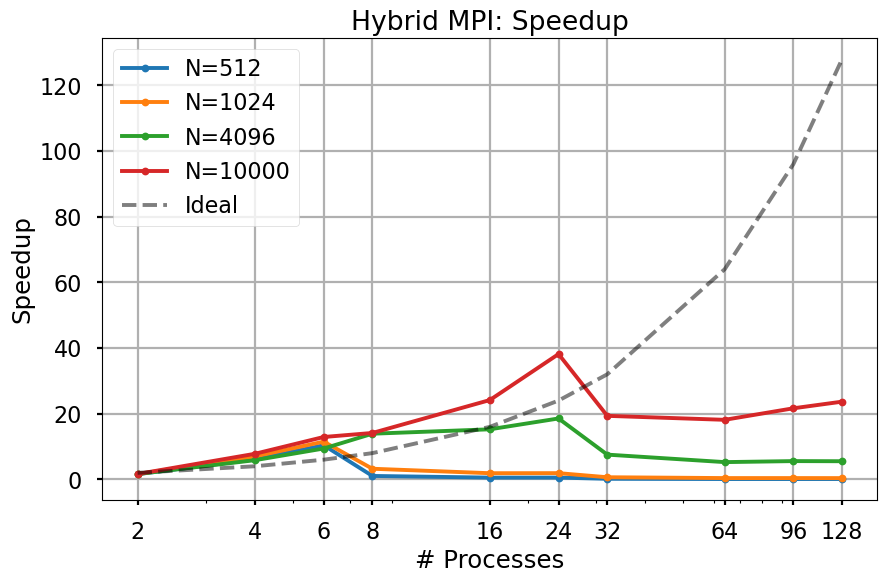

In [18]:
# Speedup
fig_opt_speedup, ax_opt_speedup = generic_performance_plot(opt_speedup_presentation, True, [True, False], False, ".-")
ax_opt_speedup.legend()
ax_opt_speedup.set_title("Hybrid MPI: Speedup")
ax_opt_speedup.set_xlabel("# Processes")
ax_opt_speedup.set_ylabel("Speedup")

fig_opt_speedup.savefig("../figures/hybrid_mpi_speedup.png", bbox_inches="tight")

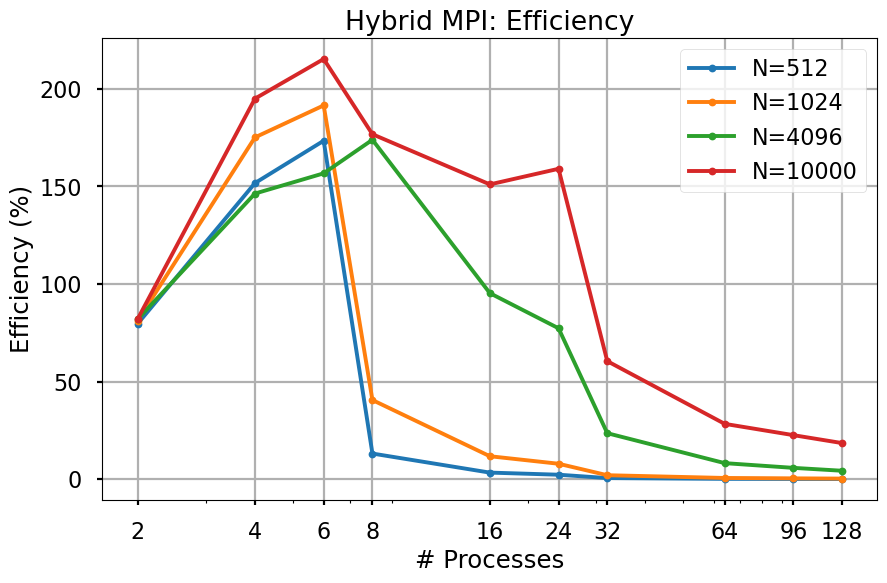

In [19]:
# Efficiencies
fig_opt_efficiency, ax_opt_efficiency = generic_performance_plot(opt_efficiency_presentation, False, [True, False], False, ".-")
ax_opt_efficiency.legend()
ax_opt_efficiency.set_title("Hybrid MPI: Efficiency")
ax_opt_efficiency.set_xlabel("# Processes")
ax_opt_efficiency.set_ylabel("Efficiency (%)")

fig_opt_efficiency.savefig("../figures/hybrid_mpi_efficiency.png", bbox_inches="tight")

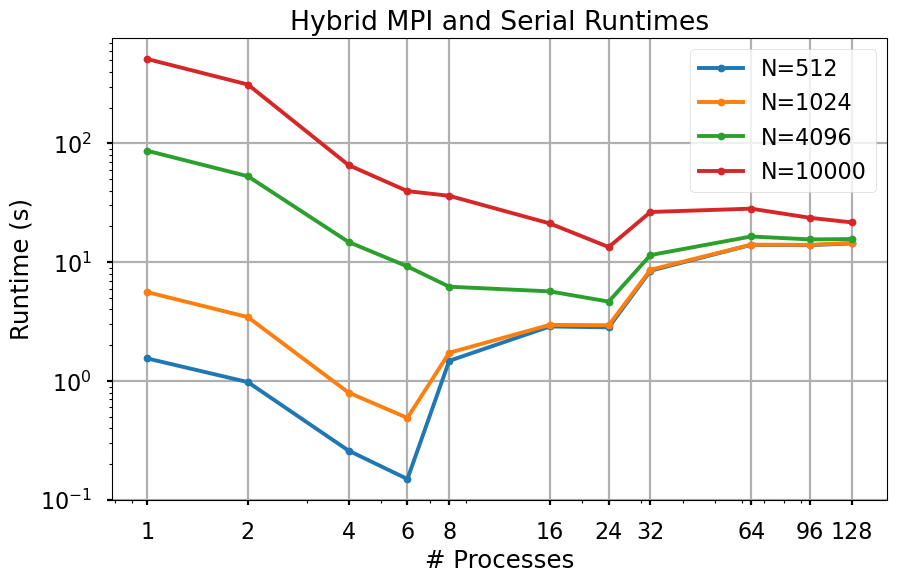

In [20]:
# Run times
# TODO: Log scale this
fig_opt_rtime, ax_opt_rtime = generic_performance_plot(opt_rtime_presentation, False, [True, True], False, ".-")
ax_opt_rtime.legend()
ax_opt_rtime.set_title("Hybrid MPI and Serial Runtimes")
ax_opt_rtime.set_xlabel("# Processes")
ax_opt_rtime.set_ylabel("Runtime (s)")

fig_opt_rtime.savefig("../figures/hybrid_mpi_runtime.png", bbox_inches="tight")